## analyses in all journeys -easiest to interpret
These analyses are in user journeys that took place on GOV.UK in the week 29-10-2018 to 04-11-2018.

dlo = 'drop length one'
kloo = 'keep length one only'

These analyses are similar to the other PREFIX_journey_eda notebooks but include all journey types regardless of frequency or length.

These results are easier to interpret than those in the other journey EDA notebooks because there are fewer caveats to measurements. 

In [15]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from beakerx import *
from tqdm._tqdm_notebook import tqdm_notebook
from notebook_functions import get_end_page, count_desktop, derive_new_variables, groupby_percent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import data

In [2]:
DATADIR = os.path.join(os.getenv("GDRIVE_DATADIR"), 'processed_journey')
DATADIR

'/Volumes/GoogleDrive/Team Drives/GOV.UK teams/2018-2019/Q3/Knowledge up Q3/Data science/data/processed_journey'

In [3]:
#the 'drop length one' data read into pandas dataframe
dlo = pd.read_csv(os.path.join(DATADIR, "dlo_prelim_meta_standard_with_pageseq_from_29-10_to_04-11-2018.csv.gz"), compression='gzip')
#the 'keep length one only' data read into pandas dataframe
kloo = pd.read_csv(os.path.join(DATADIR, "kloo_prelim_meta_standard_with_pageseq_from_29-10_to_04-11-2018.csv.gz"), compression='gzip')

In [4]:
#get number of rows, columns
print(dlo.shape, kloo.shape)

(3788851, 15) (890977, 15)


### Sample data for speed

In [123]:
#get a reproducible sample of 1% of journey types from each dataframe, 
#sampled in proportion to the number of occurrences of each journey type
#then join the new samples together into a single dataframe

journeys = pd.concat([dlo.sample(frac=0.01, random_state=1234, weights=dlo.Occurrences).copy(), kloo.sample(frac=0.01, random_state=1234, weights=kloo.Occurrences).copy()], ignore_index=True)

In [124]:
#get number of rows, columns in sampled data
journeys.shape

(46799, 15)

In [125]:
#look at distribution of occurrences
journeys['Occurrences'].describe()

count    46799.000000 
mean     149.196179   
std      3023.963701  
min      1.000000     
25%      1.000000     
50%      1.000000     
75%      12.000000    
max      362010.000000
Name: Occurrences, dtype: float64

### derive variables (create features...)

In [126]:
journeys = derive_new_variables(journeys).copy()

creating page sequence length vars
Creating search vars
creating final_page_type


### Device used

more_desktop
0    21944
1    24855
dtype: int64


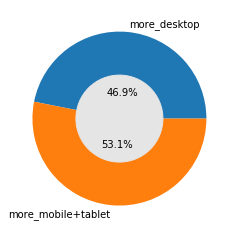

In [127]:
print(journeys.groupby('more_desktop').size())
plt.pie(journeys.groupby('more_desktop').size(), 
        labels=['more_desktop', 'more_mobile+tablet'], 
        autopct='%1.1f%%', 
        pctdistance=0.3)



# add a circle at the center
my_circle=plt.Circle( (0,0), 0.5, color='#E5E5E5')
p=plt.gcf()
p.gca().add_artist(my_circle)

### journey-level data (row per session)

In [128]:
#repeat rows for each occurrence
#make a smaller copy of data with a specific column list (to reduce memory) ready to make it really looooong
slim = journeys[['Occurrences',
                 'final_page',
                 'page_seq_len', 
                 'page_seq_len_NL', 
                 'event_list_contains_start', 
                 'count_search', 
                 'contains_search_regex', 
                 'page_list_NL_eval', 
                 'Page_Seq_NL', 
                 'page_seq_contains_start', 
                 'page_seq_contains_service.gov.uk']].copy()

journey_expanded =  journeys.loc[journeys.index.repeat(journeys['Occurrences'])].copy()

In [129]:
journey_expanded.shape

(6982232, 35)

In [130]:
#There should be a row in journeys_expanded for each occurence in journeys
journeys.Occurrences.sum()

6982232

In [131]:
#Create a variable to identify individual journey types
journey_expanded['journey_type'] = journey_expanded.index

#create a variable to identify individual journeys (can be multiple journeys per journey type if Occurences > 1)
journey_expanded.reset_index(inplace=True)
journey_expanded['journey'] = journey_expanded.index

## Journey length 
Use expanded journeys so the distributions take into account the number of occurences

In [132]:
#this is now the distribution of number of pages in journeys
journey_expanded['page_seq_len'].describe()

count    6.982232e+06
mean     1.337045e+00
std      9.830142e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.530000e+02
Name: page_seq_len, dtype: float64

In [133]:
#this is now the distribution of number of pages in journeys where self-loops have been removed
journey_expanded['page_seq_len_NL'].describe()

count    6.982232e+06
mean     1.273315e+00
std      9.111820e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.120000e+02
Name: page_seq_len_NL, dtype: float64

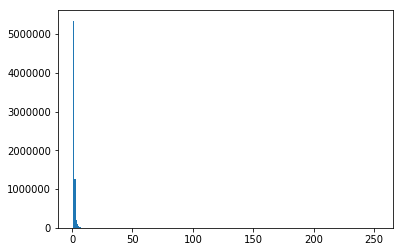

In [134]:
journey_expanded['page_seq_len'].hist(bins=253, grid=False)

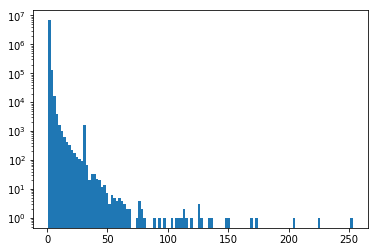

In [135]:
ax = journey_expanded['page_seq_len'].hist(bins=122, grid=False)
ax.set_yscale('log')

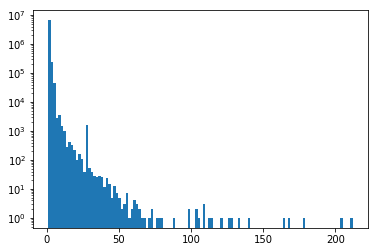

In [136]:
ax = journey_expanded['page_seq_len_NL'].hist(bins=122, grid=False)
ax.set_yscale('log')

## Search

### What proportion of journeys use search, by journey length

In [137]:
print("{}/{} ({}%) of journeys contain internal search in their path".format(journeys['contains_search_n'].sum(),
                                                                             journeys['Page_Seq_Occurrences'].sum(),
                                                                             journeys['contains_search_n'].sum()/journeys['Page_Seq_Occurrences'].sum()*100))

786118/340084927 (0.23115343774115574%) of journeys contain internal search in their path


find the proportion of journeys which contain search for each journey length.

Do this in journeys (journey-type level) but could do this in journeys to make the deonominator easier to calculate

In [138]:
data = []
for i in range(journeys['page_seq_len'].max()):
    df = journeys[journeys['page_seq_len']==i+1]
    if df['Page_Seq_Occurrences'].sum()>=1:
            percent = round(df['contains_search_n'].sum()/df['Page_Seq_Occurrences'].sum()*100, 1)
            n = df['contains_search_n'].sum()
            denom = df['Page_Seq_Occurrences'].sum()
            p = percent/100
            variance = (p*(1-p))/denom
            data.append([i+1, n, denom, percent, variance])

search_seqlength = pd.DataFrame(data, columns=['length', 'n', 'denom','percent', 'variance'])

In [139]:
search_seqlength.head()

,length,n,denom,percent,variance
0,1,264149,304589709,0.1,3.279822e-12
1,2,415961,31286493,1.3,4.101131e-10
2,3,92285,2353912,3.9,1.592201e-08
3,4,9318,1231221,0.8,6.445634e-09
4,5,1703,515145,0.3,5.806132e-09


In [140]:
search_seqlength['length'].describe()

count    94.000000 
mean     60.670213 
std      51.329923 
min      1.000000  
25%      24.250000 
50%      47.500000 
75%      78.750000 
max      253.000000
Name: length, dtype: float64

Text(0, 0.5, 'Percent of journeys used internal search')

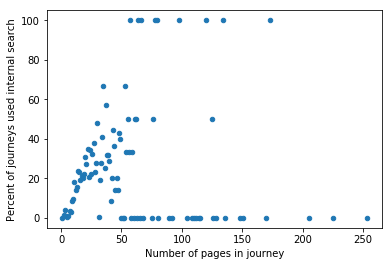

In [141]:
ax = search_seqlength.plot.scatter(x='length', y='percent')
ax.set_xlabel("Number of pages in journey")
ax.set_ylabel("Percent of journeys used internal search")

Text(0, 0.5, 'Percent of journeys used internal search')

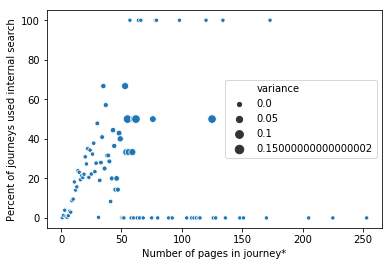

In [142]:
ax = sns.scatterplot(x="length", y="percent", size="variance", data=search_seqlength)
ax.set_xlabel("Number of pages in journey*")
ax.set_ylabel("Percent of journeys used internal search")

### How many times is search used within a single journey

In [143]:
journeys['count_search'].describe()

count    46799.000000
mean     0.176478    
std      0.850652    
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      0.000000    
max      45.000000   
Name: count_search, dtype: float64

In [144]:
journeys[journeys['contains_search_regex']==1].count_search.describe()

count    4159.000000
mean     1.985814   
std      2.133144   
min      1.000000   
25%      1.000000   
50%      1.000000   
75%      2.000000   
max      45.000000  
Name: count_search, dtype: float64

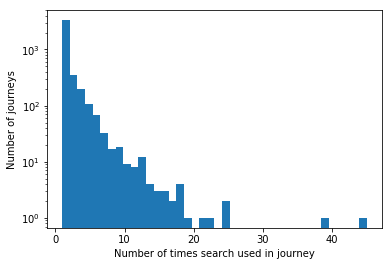

In [145]:
ax = journeys[journeys['contains_search_regex']==1].count_search.hist(bins=40, grid=False)
ax.set_xlabel("Number of times search used in journey")
ax.set_ylabel("Number of journeys")
ax.set_yscale('log')

### How many times is search used within a single journey, by journey length

(0, 312)

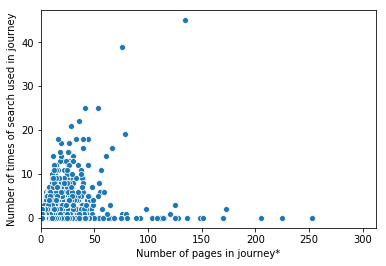

In [146]:
ax = sns.scatterplot(x="page_seq_len", y="count_search", data=journey_expanded)
ax.set_xlabel("Number of pages in journey*")
ax.set_ylabel("Number of times of search used in journey")
ax.set_xlim(0, 312)

## Most visited pages

### Page-level dataframe
Create a page-level dataframe (1 row per page in journey). That's a lot of rows and the df gets huge so it takes while and hammers memory. That's why these sections are commented out so they do not automatically run in a 'run all'

In [147]:
# this gives me a new row for every page in the no loop page list in the data which already has a row for every occurrence

# set up progress bar
tqdm_notebook.pandas(desc='progress creating series...')
# create a pandas series for each page in page sequence, where the index is for each journey 
s = journey_expanded.progress_apply(lambda x: pd.Series(x['page_list_NL_eval']),axis=1)
print("Stacking s")
s = s.stack()
print("resetting index")
s.reset_index(level=1, drop=True, inplace=True)
#Give the series a name attribute
print("Naming series")
s.name = 'page'


Stacking s
resetting index
Naming series


In [148]:
print("Creating page_expanded using join")
#Add page column to journey, joining on index to expand rows
page_expanded = journey_expanded.join(s).copy()

Creating page_expanded using join


In [149]:
page_expanded.head()

,index,Sequence,Occurrences,DeviceCategories,Dates,Page_Event_List,Page_List,PageSequence,Event_List,num_event_cats,...,mobile,other_device,more_desktop,final_page_type,final_interaction_type,final_external_link,exit_to_assessed_service,journey_type,journey,page
0,0,/check-vehicle-tax<<PAGE<:<NULL<:<NULL>>/check-vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicleenquiry.service.gov.uk>>/vehicle-tax<<PAGE<:<NULL<:<NULL>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk,2272,"[('mobile', 1589), ('desktop', 547), ('tablet', 136)]","[('20181031', 725), ('20181029', 486), ('20181102', 710), ('20181104', 351)]","[('/check-vehicle-tax', 'PAGE<:<NULL<:<NULL'), ('/check-vehicle-tax', 'EVENT<:<External Link Clicked<:<https://www.vehicleenquiry.service.gov.uk'), ('/vehicle-tax', 'PAGE<:<NULL<:<NULL'), ('/vehicle-tax', 'EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk')]","['/check-vehicle-tax', '/vehicle-tax']",/check-vehicle-tax>>/vehicle-tax,"[('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://www.vehicleenquiry.service.gov.uk'), ('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://www.vehicletax.service.gov.uk')]",2,...,1589,136,0,other,External Link Clicked,<https://www.vehicletax.service.gov.uk,1,0,0,/check-vehicle-tax
0,0,/check-vehicle-tax<<PAGE<:<NULL<:<NULL>>/check-vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicleenquiry.service.gov.uk>>/vehicle-tax<<PAGE<:<NULL<:<NULL>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk,2272,"[('mobile', 1589), ('desktop', 547), ('tablet', 136)]","[('20181031', 725), ('20181029', 486), ('20181102', 710), ('20181104', 351)]","[('/check-vehicle-tax', 'PAGE<:<NULL<:<NULL'), ('/check-vehicle-tax', 'EVENT<:<External Link Clicked<:<https://www.vehicleenquiry.service.gov.uk'), ('/vehicle-tax', 'PAGE<:<NULL<:<NULL'), ('/vehicle-tax', 'EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk')]","['/check-vehicle-tax', '/vehicle-tax']",/check-vehicle-tax>>/vehicle-tax,"[('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://www.vehicleenquiry.service.gov.uk'), ('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://www.vehicletax.service.gov.uk')]",2,...,1589,136,0,other,External Link Clicked,<https://www.vehicletax.service.gov.uk,1,0,0,/vehicle-tax
1,0,/check-vehicle-tax<<PAGE<:<NULL<:<NULL>>/check-vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicleenquiry.service.gov.uk>>/vehicle-tax<<PAGE<:<NULL<:<NULL>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk,2272,"[('mobile', 1589), ('desktop', 547), ('tablet', 136)]","[('20181031', 725), ('20181029', 486), ('20181102', 710), ('20181104', 351)]","[('/check-vehicle-tax', 'PAGE<:<NULL<:<NULL'), ('/check-vehicle-tax', 'EVENT<:<External Link Clicked<:<https://www.vehicleenquiry.service.gov.uk'), ('/vehicle-tax', 'PAGE<:<NULL<:<NULL'), ('/vehicle-tax', 'EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk')]","['/check-vehicle-tax', '/vehicle-tax']",/check-vehicle-tax>>/vehicle-tax,"[('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://www.vehicleenquiry.service.gov.uk'), ('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://www.vehicletax.service.gov.uk')]",2,...,1589,136,0,other,External Link Clicked,<https://www.vehicletax.service.gov.uk,1,0,1,/check-vehicle-tax
1,0,/check-vehicle-tax<<PAGE<:<NULL<:<NULL>>/check-vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicleenquiry.service.gov.uk>>/vehicle-tax<<PAGE<:<NULL<:<NULL>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk,2272,"[('mobile', 1589), ('desktop', 547), ('tablet', 136)]","[('20181031', 725), ('20181029', 486), ('20181102', 710), ('20181104', 351)]","[('/check-vehicle-tax', 'PAGE<:<NULL<:<NULL'), ('/check-vehicle-tax', 'EVENT<:<External Link Clicked<:<https://www.vehicleenquiry.service.gov.uk'), ('/vehicle-tax', 

### Checking page length in the journey dataframes is consistent with number of rows in page_expanded

In [150]:
print("Total journeys = {} \nTotal NL journey types = {} \nMean number of journeys per journey type = {}".format(
    journey_expanded.shape[0],
    journey_expanded.Page_Seq_NL.nunique(),
    journey_expanded.shape[0]/journey_expanded.Page_Seq_NL.nunique()))

Total journeys = 6982232 
Total NL journey types = 36188 
Mean number of journeys per journey type = 192.94329612026087


In [151]:
#Check consistency in the page_expanded df
print("Total journey made with loops = {} \nTotal journey types = {} \nTotal journey types without loops = {} \nTotal pages visited = {}".format(
    page_expanded.journey.nunique(),
    page_expanded.journey_type.nunique(),
    page_expanded.Page_Seq_NL.nunique(),
    page_expanded.shape[0]))

Total journey made with loops = 6982232 
Total journey types = 46799 
Total journey types without loops = 36188 
Total pages visited = 8890583


In [152]:
total_page_visits = page_expanded.shape[0]

In [153]:
#this is now the distribution of number of pages in journeys and should match the distribution found in journey_expanded above
page_expanded.groupby(['journey_type', 'journey']).size().describe()

count    6.982232e+06
mean     1.273315e+00
std      9.111820e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.120000e+02
dtype: float64

In [154]:
page_expanded.groupby([ 'journey']).size().describe()

count    6.982232e+06
mean     1.273315e+00
std      9.111820e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.120000e+02
dtype: float64

Oh good, this is distribution of number of pages per journey and now matches journey_expanded['page_seq_len_NL'].describe()

### Repeated pages in a journey 

In [155]:
# So I don't want to have more than one row for a page if it appeared twice in a session.
# I think that's because we might expect pages to be viewed multiple times in a session for both the do-a-thing and chang-a-thing journeys
# So I'm going to drop duplicate rows for a page within the same journey

page_expanded_no_repeats = page_expanded.drop_duplicates(['journey', 'page']).copy()

In [156]:
print("Total journey made with loops = {} \nTotal journey types = {} \nTotal journey types without loops = {} \nUnique pages visited = {}".format(
    page_expanded_no_repeats.journey.nunique(),
    page_expanded_no_repeats.journey_type.nunique(),
    page_expanded_no_repeats.Page_Seq_NL.nunique(),
    page_expanded_no_repeats.shape[0]))

Total journey made with loops = 6982232 
Total journey types = 46799 
Total journey types without loops = 36188 
Unique pages visited = 8747943


In [157]:
print("So there were {} pages that were visited at least once in a journey and won't be counted from now".format(
page_expanded.shape[0]-page_expanded_no_repeats.shape[0]))

So there were 142640 pages that were visited at least once in a journey and won't be counted from now


In [158]:
print("The mean number of visits to a single page in a journey ={}".format(
    total_page_visits/page_expanded_no_repeats.shape[0]))

The mean number of visits to a single page in a journey =1.016305547486992


In [159]:
#This gives the distribution of the number of times the same page was visited in a journey
page_expanded.groupby(['journey', 'page']).size().describe()

count    8.747943e+06
mean     1.016306e+00
std      1.605303e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+02
dtype: float64

Most journeys (>=75%) (without loops) only visit a page once. The average is 1.25 because a small number of jounreys visit a page many times

### Page visit frequency at journey-level
We have a lot of page hit data in Google Analytics but it doesn't take into account repeated hits in the same session. In the following analyses, a page is only counted once in a journey, regardless of how many times it was visited.

In [160]:
#This gives the distribution of the number of journeys containing a page
page_expanded_no_repeats.groupby([ 'page']).size().describe()

count    35387.000000 
mean     247.207816   
std      5817.836067  
min      1.000000     
25%      1.000000     
50%      1.000000     
75%      4.000000     
max      565351.000000
dtype: float64

This is the distribution of number of journeys containing a page. Some pages are in lots of journeys (>10000) and half of pages are only in one. The mean number of jounreys a page is in is 859. 

In [161]:
#These are the topmost represented pages in the journeys we sampled
page_expanded_no_repeats.groupby([ 'page']).size().sort_values(ascending=False).head(20)

page
/sign-in-universal-credit                       565351
/vehicle-tax                                    497762
/get-information-about-a-company                316551
/government/organisations/companies-house       291079
/check-vehicle-tax                              281638
/                                               269506
/log-in-register-hmrc-online-services           250611
/done/vehicle-tax                               225542
/view-driving-licence                           140358
/check-mot-status                               128894
/jobsearch                                      119276
/government/organisations/hm-revenue-customs    118818
/student-finance-register-login                 110043
/get-vehicle-information-from-dvla              109108
/universal-credit                               101132
/pay-dartford-crossing-charge                   96371 
/make-a-sorn                                    83975 
/contact/govuk/anonymous-feedback/thankyou      83543 
/bank

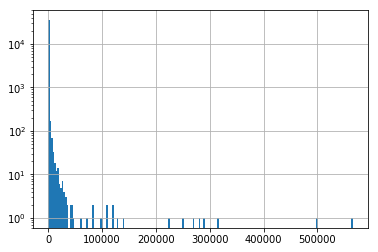

In [162]:
ax = page_expanded_no_repeats.groupby([ 'page']).size().hist(bins=200)
ax.set_yscale('log')

### Volume of content that is most visited in journeys

Using Google analytics, there's a 2% of content is in 80% of sessions result that is used to define mainstream by some people. When you remove repeated visits per session, what's the relationship between frequency of page visits and cumulative volume of content

In [163]:
print("There are {} different pages".format(
    page_expanded_no_repeats.groupby([ 'page']).size().sort_values(ascending=False).shape[0]))

unique_pages = page_expanded_no_repeats.groupby([ 'page']).size().sort_values(ascending=False).shape[0]

There are 35387 different pages


In [164]:
top_2_percent = page_expanded_no_repeats.groupby([ 'page']).size().nlargest(int(unique_pages * 0.02))

In [165]:
print("the top 2% of pages are visited in {}% of journeys".format(
    top_2_percent.sum()/page_expanded_no_repeats.groupby([ 'page']).size().sum()))

the top 2% of pages are visited in 0.8677004411208441% of journeys


In [166]:
percent = 0.13

print("the top {}% of pages are visited in {}% of journeys".format(
    percent * 100,
    page_expanded_no_repeats.groupby([ 'page']).size().nlargest(int(unique_pages * percent)).sum()/page_expanded_no_repeats.groupby([ 'page']).size().sum()))

the top 13.0% of pages are visited in 0.9907674295545822% of journeys


In [170]:
data = []
for i in tqdm_notebook(np.arange(0.0, 1.0, 0.01)):
    percent_of_pages = i*100
    n = page_expanded_no_repeats.groupby([ 'page']).size().nlargest(int(unique_pages * i)).sum()
    percent_of_journeys = n/page_expanded_no_repeats.groupby([ 'page']).size().sum()*100
    data.append([percent_of_pages, n, percent_of_journeys])

journey_to_content_relationship = pd.DataFrame(data, columns=['percent_of_pages', 'number_of_pages', 'percent_of_journeys'])

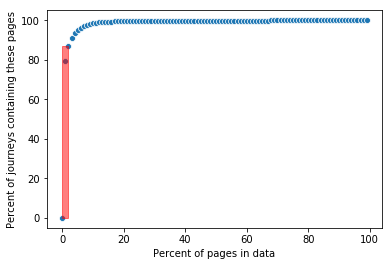

In [172]:
ax = sns.scatterplot(x="percent_of_pages", y="percent_of_journeys", data=journey_to_content_relationship)
ax.set_xlabel("Percent of pages in data")
ax.set_ylabel("Percent of journeys containing these pages")


# Create a Rectangle patch
rect = patches.Rectangle((0,0),
                         2,
                         top_2_percent.sum()/page_expanded_no_repeats.groupby([ 'page']).size().sum()*100,
                         linewidth=1,edgecolor='r',
                         facecolor='red', 
                         fill=True, 
                         alpha=0.5
                        )
# rect2 = patches.Rectangle((0,0),13,84,linewidth=1,edgecolor='blue',facecolor='blue', fill=True, alpha=0.05)
# Add the patch to the Axes
ax.add_patch(rect)
# ax.add_patch(rect2)

In [ ]:
# ax = sns.scatterplot(x="percent_of_pages", y="percent_of_journeys", data=journey_to_content_relationship)
# ax.set_xlabel("Percent of pages in data")
# ax.set_ylabel("Percent of journeys containing these pages")
# ax.set_xlim(0, 20)

# # Create a Rectangle patch
# rect = patches.Rectangle((0,0),2,66,linewidth=1,edgecolor='r',facecolor='red', fill=True, alpha=0.5)

# # Add the patch to the Axes
# ax.add_patch(rect)

### journeys containing start pages

In [173]:
journey_expanded.event_list_contains_start.value_counts()

0    6947736
1    34496  
Name: event_list_contains_start, dtype: int64

In [174]:
journey_expanded.event_list_contains_start.value_counts(normalize=True)

0    0.995059
1    0.004941
Name: event_list_contains_start, dtype: float64

In [175]:
journey_expanded.page_seq_contains_start.value_counts()

0    6935110
1    47122  
Name: page_seq_contains_start, dtype: int64

In [176]:
journey_expanded.page_seq_contains_start.value_counts(normalize=True)

0    0.993251
1    0.006749
Name: page_seq_contains_start, dtype: float64

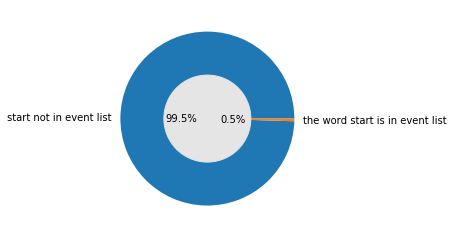

In [177]:
plt.pie(journey_expanded.event_list_contains_start.value_counts(), 
        labels=['start not in event list', 'the word start is in event list'], 
        autopct='%1.1f%%', 
        pctdistance=0.3)

# add a circle at the center
my_circle=plt.Circle( (0,0), 0.5, color='#E5E5E5')
p=plt.gcf()
p.gca().add_artist(my_circle)

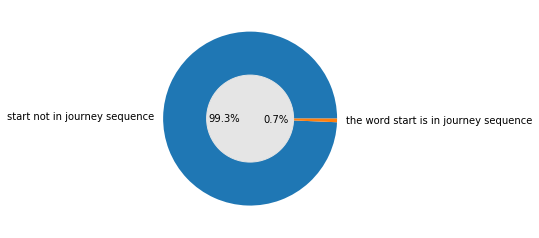

In [178]:
plt.pie(journey_expanded.page_seq_contains_start.value_counts(), 
        labels=['start not in journey sequence', 'the word start is in journey sequence'], 
        autopct='%1.1f%%', 
        pctdistance=0.3)

# add a circle at the center
my_circle=plt.Circle( (0,0), 0.5, color='#E5E5E5')
p=plt.gcf()
p.gca().add_artist(my_circle)

### Identifying journeys that go to service
the domain service.gov.uk identifies only those services which has passed a service assessment and therefore does not include legacy services or those hosted on other domains for different reasons.

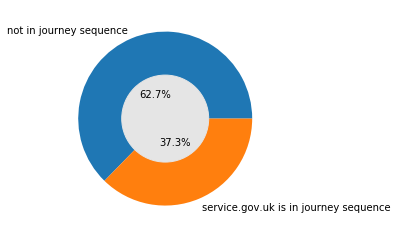

In [179]:
plt.pie(journey_expanded['page_seq_contains_service.gov.uk'].value_counts(), 
        labels=['not in journey sequence', 'service.gov.uk is in journey sequence'], 
        autopct='%1.1f%%', 
        pctdistance=0.3)

# add a circle at the center
my_circle=plt.Circle( (0,0), 0.5, color='#E5E5E5')
p=plt.gcf()
p.gca().add_artist(my_circle)

### End/final page as a proxy for 'destination'

In [180]:
print("There are {} different 'destination' pages in the sample. I used quotes because there are a few too many assumptions here to be sure"
      " that the final page was the intended destination so...".format(journeys['final_page'].nunique()))

There are 14517 different 'destination' pages (there are a few too many assumptions here to be sure that the final page was the intended destination but...


#### most frequent end pages

In [181]:
journey_expanded.groupby('final_page').size().describe()

count    14517.000000 
mean     480.969346   
std      8080.920868  
min      1.000000     
25%      1.000000     
50%      2.000000     
75%      54.000000    
max      560033.000000
dtype: float64

In [182]:
journey_expanded.groupby('final_page').size().sort_values(ascending=False)

final_page
/sign-in-universal-credit                                                                                                                                                                             560033
/vehicle-tax                                                                                                                                                                                          457414
/get-information-about-a-company                                                                                                                                                                      310703
/check-vehicle-tax                                                                                                                                                                                    273741
/log-in-register-hmrc-online-services                                                                                                                                    

You can compare the most frequent 'destination' pages with the most frequently visited pages (at journey-level), that are listed above

Text(0.5, 0, 'Number of journeys where page is final')

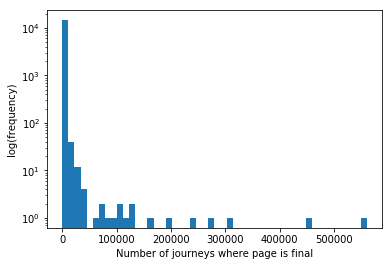

In [183]:
ax = journey_expanded.groupby('final_page').size().hist(bins=50, grid=False)
ax.set_yscale('log')
ax.set_ylabel("log(frequency)")
ax.set_xlabel("Number of journeys where page is final")

### Most number of 'ways' of getting there

In [184]:
print("On average there are {} journeys per exit page; ways of getting there".format(journeys.shape[0]/journeys['final_page'].nunique()))

On average there are 3.2237376868499 journeys per exit page; ways of getting there


In [185]:
unique_page_sequences = journeys.drop_duplicates('Page_Seq_NL')

In [186]:
unique_page_sequences.groupby('final_page').size().describe()

count    14517.000000
mean     2.492802    
std      8.518748    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      2.000000    
max      418.000000  
dtype: float64

In [187]:
unique_page_sequences.groupby('final_page').size().sort_values(ascending=False)

final_page
/                                                                                                                                                                                                         418
/log-in-register-hmrc-online-services                                                                                                                                                                     338
/vehicle-tax                                                                                                                                                                                              336
/sign-in-universal-credit                                                                                                                                                                                 250
/get-information-about-a-company                                                                                                                                     

In [188]:
#Vehicle tax has a pretty diverse set of paths to it. Let's have a little look
pd.set_option('display.max_colwidth', -1)
unique_page_sequences[unique_page_sequences['final_page']=='/vehicle-tax'].head()

,Sequence,Occurrences,DeviceCategories,Dates,Page_Event_List,Page_List,PageSequence,Event_List,num_event_cats,Event_cats_agg,...,contains_search_regex,contains_search_n,desktop,mobile,other_device,more_desktop,final_page_type,final_interaction_type,final_external_link,exit_to_assessed_service
0,/check-vehicle-tax<<PAGE<:<NULL<:<NULL>>/check-vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicleenquiry.service.gov.uk>>/vehicle-tax<<PAGE<:<NULL<:<NULL>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk,2272,"[('mobile', 1589), ('desktop', 547), ('tablet', 136)]","[('20181031', 725), ('20181029', 486), ('20181102', 710), ('20181104', 351)]","[('/check-vehicle-tax', 'PAGE<:<NULL<:<NULL'), ('/check-vehicle-tax', 'EVENT<:<External Link Clicked<:<https://www.vehicleenquiry.service.gov.uk'), ('/vehicle-tax', 'PAGE<:<NULL<:<NULL'), ('/vehicle-tax', 'EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk')]","['/check-vehicle-tax', '/vehicle-tax']",/check-vehicle-tax>>/vehicle-tax,"[('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://www.vehicleenquiry.service.gov.uk'), ('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://www.vehicletax.service.gov.uk')]",2,"[('PAGE_NULL', 2), ('External Link Clicked', 2)]",...,0,0,547,1589,136,0,other,External Link Clicked,<https://www.vehicletax.service.gov.uk,1
20,/sold-bought-vehicle<<PAGE<:<NULL<:<NULL>>/sold-bought-vehicle/y<<PAGE<:<NULL<:<NULL>>/sold-bought-vehicle/y/yes<<PAGE<:<NULL<:<NULL>>/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade<<PAGE<:<NULL<:<NULL>>/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade<<EVENT<:<Simple Smart Answer<:<Completed>>/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade<<EVENT<:<External Link Clicked<:<https://www.buysellvehicle.service.gov.uk/buy-motor-trade/setup-trade-details>>/vehicle-tax<<PAGE<:<NULL<:<NULL>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk,444,"[('desktop', 424), ('tablet', 12), ('mobile', 8)]","[('20181031', 188), ('20181029', 109), ('20181102', 122), ('20181104', 25)]","[('/sold-bought-vehicle', 'PAGE<:<NULL<:<NULL'), ('/sold-bought-vehicle/y', 'PAGE<:<NULL<:<NULL'), ('/sold-bought-vehicle/y/yes', 'PAGE<:<NULL<:<NULL'), ('/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade', 'PAGE<:<NULL<:<NULL'), ('/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade', 'EVENT<:<Simple Smart Answer<:<Completed'), ('/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade', 'EVENT<:<External Link Clicked<:<https://www.buysellvehicle.service.gov.uk/buy-motor-trade/setup-trade-details'), ('/vehicle-tax', 'PAGE<:<NULL<:<NULL'), ('/vehicle-tax', 'EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk')]","['/sold-bought-vehicle', '/sold-bought-vehicle/y', '/sold-bought-vehicle/y/yes', '/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade', '/vehicle-tax']",/sold-bought-vehicle>>/sold-bought-vehicle/y>>/sold-bought-vehicle/y/yes>>/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade>>/vehicle-tax,"[('PAGE_NULL', 'PAGE_NULL'), ('PAGE_NULL', 'PAGE_NULL'), ('PAGE_NULL', 'PAGE_NULL'), ('PAGE_NULL', 'PAGE_NULL'), ('Simple Smart Answer', 'Completed'), ('External Link Clicked', 'https://www.buysellvehicle.service.gov.uk/buy-motor-trade/setup-trade-details'), ('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://www.vehicletax.service.gov.uk')]",3,"[('PAGE_NULL', 5), ('Simple Smart Answer', 1), ('External Link Clicked', 2)]",...,0,0,424,8,12,1,other,External Link Clicked,<https://www.vehicletax.service.gov.uk,1
66,/vehicle-tax<<PAGE<:<NULL<:<NULL>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk>>/vehicle-tax<<PAGE<:<NULL<:<NULL>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://w

In [189]:
#This variable is defined from keywords within the final page that might give a clue to what the page does
journeys.groupby('final_page_type').size()

final_page_type
apply                     2123 
calculate/calculator      1126 
change                    1287 
check                     3489 
claim                     1381 
contact/enquiries         1444 
eligibility               403  
estimate                  62   
find                      787  
get_information           172  
government_publication    5749 
login                     2127 
manage                    396  
order                     216  
other                     22236
pay                       2522 
renew                     707  
send                      299  
update                    273  
dtype: int64

(           final_page_type  Page_Seq_NL    percent
 7   estimate                62           0.132481 
 9   get_information         172          0.367529 
 13  order                   216          0.461548 
 18  update                  273          0.583346 
 17  send                    299          0.638903 
 12  manage                  396          0.846172 
 6   eligibility             403          0.861130 
 16  renew                   707          1.510716 
 8   find                    787          1.681660 
 1   calculate/calculator    1126         2.406034 
 2   change                  1287         2.750059 
 4   claim                   1381         2.950918 
 5   contact/enquiries       1444         3.085536 
 0   apply                   2123         4.536422 
 11  login                   2127         4.544969 
 15  pay                     2522         5.389004 
 3   check                   3489         7.455288 
 10  government_publication  5749         12.284451
 14  other  

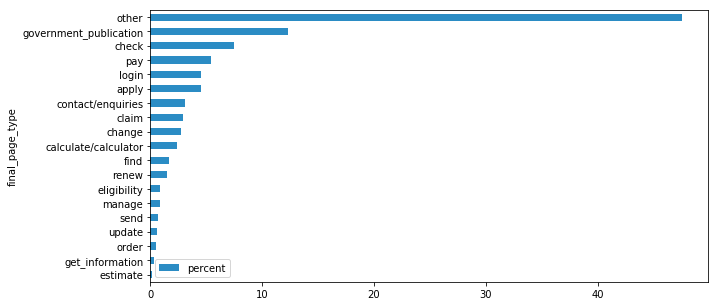

In [190]:
#Here's the percentage distribution
groupby_percent(journeys, 'final_page_type', 'Page_Seq_NL')

## Final interaction with GOV.UK

In [191]:
# what do 'start' at end of journey look like?
journeys[journeys.final_interaction.str.contains('start')]

Sequence  \
100    /check-mot-history<<PAGE<:<NULL<:<NULL>>/check-mot-history<<EVENT<:<relatedLinkClicked<:<2.3 Explore the topic>>/topic/mot/get-check-mot<<PAGE<:<NULL<:<NULL>>/topic/mot/get-check-mot<<EVENT<:<navSubtopicContentItemLinkClicked<:<1.2>>/mot-reminder<<PAGE<:<NULL<:<NULL>>/mot-reminder<<EVENT<:<External Link Clicked<:<https://www.reminders.mot-testing.service.gov.uk/start                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

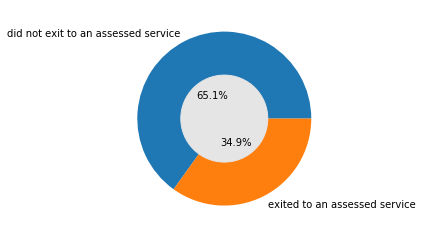

In [193]:
#What's the number of final pages that go to an e=assessed service. 
plt.pie(journey_expanded['exit_to_assessed_service'].value_counts(), 
        labels=['did not exit to an assessed service', 'exited to an assessed service'], 
        autopct='%1.1f%%', 
        pctdistance=0.3)

# add a circle at the center
my_circle=plt.Circle( (0,0), 0.5, color='#E5E5E5')
p=plt.gcf()
p.gca().add_artist(my_circle)

that's a bit lower than those containing a service.gov.uk anywhere in the journey (37%) which is what you'd expect...

(               final_interaction_type  PageSequence    percent
 11  UX                                 1             0.002137 
 19  home_office_research_survey_3      1             0.002137 
 17  home_office_research_survey_1      1             0.002137 
 23  navSubtopicLinkClicked             1             0.002137 
 31  servicesDocumentListClicked        1             0.002137 
 22  navFinderLinkClicked               1             0.002137 
 26  postcodeSearch:local_transaction   1             0.002137 
 18  home_office_research_survey_2      2             0.004274 
 16  firstLevelBrowseLinkClicked        2             0.004274 
 21  navDocumentCollectionLinkClicked   2             0.004274 
 36  userAlerts:find_local_council      2             0.004274 
 32  social media                       3             0.006410 
 5   Onsite Feedback                    3             0.006410 
 38  userAlerts:place                   3             0.006410 
 34  stepNavLinkClicked                 

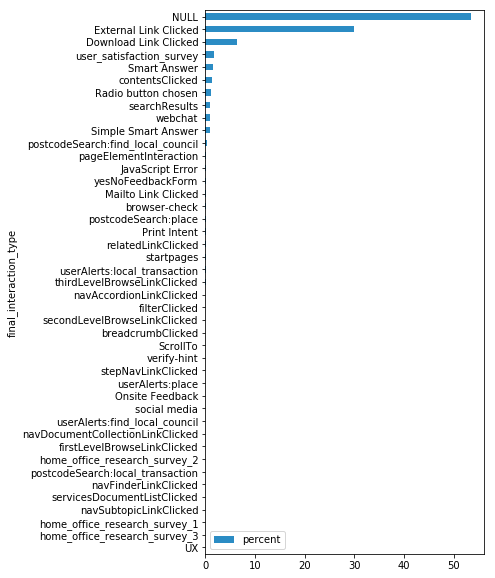

In [194]:
groupby_percent(journeys, 'final_interaction_type', 'PageSequence', figsize=(5, 10))

In [195]:
journeys.groupby('final_interaction_type').size().sort_values(ascending=False)

final_interaction_type
NULL                                 25054
External Link Clicked                13997
Download Link Clicked                3025 
user_satisfaction_survey             785  
Smart Answer                         746  
contentsClicked                      666  
Radio button chosen                  545  
searchResults                        443  
webchat                              422  
Simple Smart Answer                  409  
postcodeSearch:find_local_council    180  
pageElementInteraction               80   
JavaScript Error                     77   
yesNoFeedbackForm                    68   
Mailto Link Clicked                  59   
browser-check                        37   
postcodeSearch:place                 32   
Print Intent                         25   
relatedLinkClicked                   21   
startpages                           20   
userAlerts:local_transaction         15   
thirdLevelBrowseLinkClicked          14   
navAccordionLinkClicked        